<a id='Top'></a>

# Multisurv model training<a class='tocSkip'></a>

Train MultiSurv models with different combinations of input data modalities.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import ipywidgets as widgets
import pandas as pd
import torch

if torch.cuda.is_available():
    print('>>> PyTorch detected CUDA <<<')

# Make modules in "src" dir visible
if os.getcwd() not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'src'))

import utils
from model import Model

>>> PyTorch detected CUDA <<<


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Different-intervals" data-toc-modified-id="Different-intervals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Different intervals</a></span><ul class="toc-item"><li><span><a href="#Equidistant-times" data-toc-modified-id="Equidistant-times-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Equidistant times</a></span></li><li><span><a href="#By-duration-quantiles" data-toc-modified-id="By-duration-quantiles-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>By duration quantiles</a></span></li></ul></li><li><span><a href="#Pick-learning-rate" data-toc-modified-id="Pick-learning-rate-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pick learning rate</a></span></li><li><span><a href="#Fit" data-toc-modified-id="Fit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Fit</a></span><ul class="toc-item"><li><span><a href="#Save-model-weights" data-toc-modified-id="Save-model-weights-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Save model weights</a></span></li></ul></li><li><span><a href="#Check-validation-metrics" data-toc-modified-id="Check-validation-metrics-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check validation metrics</a></span></li></ul></li></ul></div>

In [2]:
import torch
import subprocess

def check_gpu_setup():
    """Complete GPU detection and verification."""
    
    print("=== GPU DETECTION REPORT ===")
    
    # 1. Check CUDA availability
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"PyTorch version: {torch.__version__}")
    
    if not torch.cuda.is_available():
        print("❌ CUDA not available - will use CPU")
        return
    
    # 2. Check number of GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of CUDA devices: {gpu_count}")
    
    # 3. List all available GPUs
    print("\n=== AVAILABLE GPUS ===")
    for i in range(gpu_count):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}")
        print(f"  Memory: {props.total_memory / 1024**3:.1f} GB")
        print(f"  Compute Capability: {props.major}.{props.minor}")
        print(f"  Multi Processors: {props.multi_processor_count}")
    
    # 4. Check current device
    current_device = torch.cuda.current_device()
    current_name = torch.cuda.get_device_name(current_device)
    print(f"\n=== CURRENT SELECTION ===")
    print(f"Current CUDA device: {current_device}")
    print(f"Current GPU name: {current_name}")
    
    # 5. Memory usage
    if torch.cuda.is_available():
        print(f"\n=== MEMORY USAGE ===")
        for i in range(gpu_count):
            allocated = torch.cuda.memory_allocated(i) / 1024**3
            reserved = torch.cuda.memory_reserved(i) / 1024**3
            total = torch.cuda.get_device_properties(i).total_memory / 1024**3
            print(f"GPU {i} ({torch.cuda.get_device_name(i)}):")
            print(f"  Allocated: {allocated:.2f} GB")
            print(f"  Reserved: {reserved:.2f} GB")
            print(f"  Total: {total:.1f} GB")
    
    # 6. Test tensor creation on GPU
    print(f"\n=== GPU FUNCTIONALITY TEST ===")
    try:
        # Create test tensor on GPU
        test_tensor = torch.randn(1000, 1000).cuda()
        result = torch.mm(test_tensor, test_tensor)
        print(f"✅ GPU computation successful")
        print(f"Test tensor device: {test_tensor.device}")
        print(f"Result tensor device: {result.device}")
        
        # Cleanup
        del test_tensor, result
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"❌ GPU computation failed: {e}")

def check_nvidia_system():
    """Check NVIDIA system information."""
    print("\n=== NVIDIA SYSTEM INFO ===")
    
    try:
        # Run nvidia-smi command
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
        if result.returncode == 0:
            print("NVIDIA-SMI Output:")
            print(result.stdout)
        else:
            print("❌ nvidia-smi command failed")
            print(result.stderr)
    except FileNotFoundError:
        print("❌ nvidia-smi not found - NVIDIA drivers may not be installed")
    except Exception as e:
        print(f"❌ Error running nvidia-smi: {e}")

def set_gpu_preference():
    """Set GPU preference if multiple GPUs available."""
    
    if not torch.cuda.is_available():
        print("No CUDA GPUs available")
        return None
    
    gpu_count = torch.cuda.device_count()
    
    if gpu_count == 1:
        device = torch.device('cuda:0')
        print(f"✅ Using single GPU: {torch.cuda.get_device_name(0)}")
        return device
    
    print(f"\n=== MULTIPLE GPUS DETECTED ({gpu_count}) ===")
    
    # Show GPU options
    for i in range(gpu_count):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name} ({props.total_memory / 1024**3:.1f} GB)")
    
    # Find the most powerful GPU (by memory)
    best_gpu = 0
    best_memory = 0
    
    for i in range(gpu_count):
        memory = torch.cuda.get_device_properties(i).total_memory
        if memory > best_memory:
            best_memory = memory
            best_gpu = i
    
    device = torch.device(f'cuda:{best_gpu}')
    print(f"✅ Auto-selected most powerful GPU: {torch.cuda.get_device_name(best_gpu)}")
    
    # Set as current device
    torch.cuda.set_device(best_gpu)
    
    return device

def verify_pytorch_gpu_usage():
    """Verify PyTorch is actually using the NVIDIA GPU (not Intel)."""
    
    print("\n=== PYTORCH GPU VERIFICATION ===")
    
    if not torch.cuda.is_available():
        print("❌ PyTorch not using GPU - will use CPU")
        return False
    
    # Create tensor and check device
    x = torch.randn(100, 100).cuda()
    gpu_name = torch.cuda.get_device_name(x.device)
    
    print(f"✅ PyTorch using: {gpu_name}")
    
    # Check if it's NVIDIA (not Intel)
    if 'nvidia' in gpu_name.lower() or 'geforce' in gpu_name.lower() or 'rtx' in gpu_name.lower() or 'gtx' in gpu_name.lower():
        print(f"✅ Confirmed: Using NVIDIA GPU")
        return True
    elif 'intel' in gpu_name.lower():
        print(f"⚠️  Warning: Using Intel GPU - this may be slow for deep learning")
        return False
    else:
        print(f"❓ Unknown GPU type: {gpu_name}")
        return True

# Run all checks
def complete_gpu_check():
    """Run complete GPU diagnostic."""
    check_gpu_setup()
    check_nvidia_system()
    device = set_gpu_preference()
    is_nvidia = verify_pytorch_gpu_usage()
    
    print(f"\n=== RECOMMENDATION ===")
    if is_nvidia and device:
        print(f"✅ Ready for GPU training with device: {device}")
        print(f"Use: multisurv.device = {device}")
    else:
        print("⚠️  Consider using CPU training: multisurv.device = torch.device('cpu')")
    
    return device

# Quick check function
def quick_gpu_check():
    """Quick GPU check for immediate feedback."""
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        print(f"🎯 PyTorch is using: {gpu_name}")
        
        if any(keyword in gpu_name.lower() for keyword in ['nvidia', 'geforce', 'rtx', 'gtx']):
            print("✅ NVIDIA GPU detected - good for training!")
        else:
            print("⚠️  Non-NVIDIA GPU detected")
    else:
        print("❌ No GPU available - will use CPU")

# Run the checks
quick_gpu_check()
print("\n" + "="*50)
complete_gpu_check()

🎯 PyTorch is using: NVIDIA GeForce RTX 4060 Laptop GPU
✅ NVIDIA GPU detected - good for training!

=== GPU DETECTION REPORT ===
CUDA available: True
CUDA version: 11.8
PyTorch version: 2.4.0
Number of CUDA devices: 1

=== AVAILABLE GPUS ===
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
  Memory: 8.0 GB
  Compute Capability: 8.9
  Multi Processors: 24

=== CURRENT SELECTION ===
Current CUDA device: 0
Current GPU name: NVIDIA GeForce RTX 4060 Laptop GPU

=== MEMORY USAGE ===
GPU 0 (NVIDIA GeForce RTX 4060 Laptop GPU):
  Allocated: 0.00 GB
  Reserved: 0.00 GB
  Total: 8.0 GB

=== GPU FUNCTIONALITY TEST ===
✅ GPU computation successful
Test tensor device: cuda:0
Result tensor device: cuda:0

=== NVIDIA SYSTEM INFO ===
NVIDIA-SMI Output:
Sat Jul  5 14:07:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+--

device(type='cuda', index=0)

In [3]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# `DataLoader`

In [4]:
data_modalities = widgets.SelectMultiple(
    options=['clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'wsi'],
    index=[0, 1],
    rows=6,
    description='Input data',
    disabled=False
)
display(data_modalities)

SelectMultiple(description='Input data', index=(0, 1), options=('clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'w…

In [5]:
#-----------------------------------------------------------------------------#
#                             20-CANCER SUBSET                                #
#                 (to compare to Cheerla and Gevaert 2019)                    #
#-----------------------------------------------------------------------------#

cancers = ['BRCA']

labels = pd.read_csv('/app/data/labels.tsv', sep='\t')
print(labels.head(3))


   submitter_id      time  event  group
0  TCGA-Z7-A8R6  8.920548      0   test
1  TCGA-C8-A1HE  1.027397      0   test
2  TCGA-A8-A07B  3.583562      0  train


In [6]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='/app/data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=549,
                                    n_wsi_patches=5,
#                                     batch_size=20,
#                                    batch_size=64,
                                     batch_size=16,
                                   )

Data modalities:
   clinical

Dataset sizes (# patients):
   train: 710
   val: 165
   test: 219

Batch size: 16


In [7]:
# Compare event rates across splits
def get_event_rate(dataset):
    events = [e for _, e in dataset.label_map.values()]
    return sum(events) / len(events)

print(f"Train event rate: {get_event_rate(dataloaders['train'].dataset):.2%}")
print(f"Val event rate: {get_event_rate(dataloaders['val'].dataset):.2%}")
print(f"Test event rate: {get_event_rate(dataloaders['test'].dataset):.2%}")

Train event rate: 13.80%
Val event rate: 13.94%
Test event rate: 13.70%


In [8]:
# Check if clinical features are similar across splits
# Look for any systematic differences
for split in ['train', 'val', 'test']:
    data = dataloaders[split].dataset
    print(f"\n{split.upper()} set (n={len(data)}):")
    # Get first patient's clinical data to see structure
    if len(data) > 0:
        clinical = data[0]
        print(f"Clinical features shape: {clinical}")


TRAIN set (n=710):
Clinical features shape: ({'clinical': (tensor([0., 5., 0., 0., 0., 0., 2., 4.]), tensor([0.3879]))}, 8.123287671232877, 1)

VAL set (n=165):
Clinical features shape: ({'clinical': (tensor([0., 5., 0., 0., 0., 0., 2., 7.]), tensor([0.5076]))}, 2.92054794520548, 0)

TEST set (n=219):
Clinical features shape: ({'clinical': (tensor([0., 3., 0., 0., 0., 0., 2., 9.]), tensor([0.6569]))}, 3.315068493150685, 0)


# Model

## Different intervals

If trying out different time interval outputs.

### Equidistant times

In [9]:
interval_cuts = torch.arange(0., 365 * 5.1, 365 / 2)

### By duration quantiles

In [10]:
labels = [(t, e) for t, e in dataloaders['train'].dataset.label_map.values()]
durations = [t for t, _ in labels]
events = [e for _, e in labels]

interval_cuts = utils.discretize_time_by_duration_quantiles(durations, events, 20)
interval_cuts = torch.from_numpy(interval_cuts)

In [10]:
#-----------------------------------------------------------------------------#
#                       PRE-TRAINED UNIMODAL MODELS                           #
#-----------------------------------------------------------------------------#

unimodal_weigths = {'clinical': 'clinical_lr1e-06_breast_cancer_gpu_20250630_163247_epoch58_concord0.77.pth',
                        'mRNA': None,
                    'DNAm': None,
                    'miRNA': None,
                    'CNV': None,
                    'wsi': None,}

unimodal_weigths = {k: os.path.join(MODELS, v) if v is not None else None
                    for k, v in unimodal_weigths.items()}


In [11]:

multisurv = Model(
    dataloaders=dataloaders,
#    auxiliary_criterion=None,  # No auxiliary loss needed
    output_intervals=interval_cuts,
    unimodal_state_files = unimodal_weigths,
    device=device
)

Instantiating MultiSurv model...


/app/src/multisurv.py:84: UserWarning: Input data is unimodal: no fusion procedure.
  warnings.warn('Input data is unimodal: no fusion procedure.')
/app/src/model.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

(loading pretrained unimodal model weights...)


RuntimeError: Error(s) in loading state_dict for MultiSurv:
	size mismatch for risk_layer.0.weight: copying a param with shape torch.Size([17, 512]) from checkpoint, the shape in current model is torch.Size([10, 512]).
	size mismatch for risk_layer.0.bias: copying a param with shape torch.Size([17]) from checkpoint, the shape in current model is torch.Size([10]).

In [13]:
def create_gpu_enabled_multisurv():
    """Create a fresh MultiSurv instance with proper GPU setup."""
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Creating MultiSurv with device: {device}")
    
    
    # Create new model with GPU device
    gpu_multisurv = Model(
        dataloaders=multisurv.dataloaders,  # Reuse existing dataloaders
        fusion_method=multisurv.fusion_method,
        output_intervals=multisurv.output_intervals.to(device),  # Move to GPU
        unimodal_state_files = multisurv.unimodal_state_files,
        device=device  # Set device properly
    )
    
    print("✅ GPU-enabled MultiSurv created!")
    return gpu_multisurv

In [14]:
gpu_multisurv = create_gpu_enabled_multisurv()

Creating MultiSurv with device: cuda:0
Instantiating MultiSurv model...
(loading pretrained unimodal model weights...)
✅ GPU-enabled MultiSurv created!


In [22]:
print('Output intervals (in years):')
gpu_multisurv.output_intervals / 365

Output intervals (in years):


tensor([ 0.0000,  1.6767,  2.7123,  3.7342,  4.6247,  6.2712,  6.8849,  7.5808,
         8.0000,  8.9342, 10.0274, 10.6110, 10.7973, 11.7397, 17.2384, 17.6877,
        19.5233, 23.5753], device='cuda:0', dtype=torch.float64)

In [23]:
gpu_multisurv.model_blocks

['clinical_submodel', 'fc_block', 'risk_layer']

In [24]:
print('Trainable blocks:')
layer = None

for name, child in gpu_multisurv.model.named_children():
    for name_2, params in child.named_parameters():
        if name is not layer:
            print(f'   {name}: {params.requires_grad}')
        layer = name

Trainable blocks:
   clinical_submodel: True
   fc_block: True
   risk_layer: True


In [25]:
gpu_multisurv.model

MultiSurv(
  (clinical_submodel): ClinicalNet(
    (embedding_layers): ModuleList(
      (0): Embedding(2, 1)
      (1): Embedding(6, 3)
      (2-4): 3 x Embedding(2, 1)
      (5-6): 2 x Embedding(3, 2)
      (7): Embedding(12, 6)
    )
    (embedding_dropout): Dropout(p=0.5, inplace=False)
    (bn_layer): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=18, out_features=256, bias=True)
    (output_layer): FC(
      (fc): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Linear(in_features=256, out_features=512, bias=True)
        (2): ReLU()
      )
    )
  )
  (fc_block): FC(
    (fc): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=512, out_features=2048, bias=True)
      (2): ReLU()
      (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): Linear(in_features=2048, out_features=2048,

## Pick learning rate

In [15]:
# Check GPU usage after LR test
def monitor_gpu_real_time():
    import torch
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"🎯 GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    
    # Check if there are any tensors on GPU
    print(f"🔍 GPU cache size: {torch.cuda.memory_cached(0) / 1024**3:.2f} GB")
monitor_gpu_real_time()

🎯 GPU Memory: 0.17 GB allocated, 0.17 GB reserved
🔍 GPU cache size: 0.17 GB


/tmp/ipykernel_761/1937229576.py:9: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"🔍 GPU cache size: {torch.cuda.memory_cached(0) / 1024**3:.2f} GB")


In [16]:
# GPU-compatible version of the completely fixed LR test

def gpu_fixed_lr_test_run(self, init_value=1e-8, final_value=10., beta=0.98):
    """GPU-compatible LR test that ensures all tensors are on the same device."""
    print(">>> Using GPU-COMPATIBLE FIXED lr_test.run method")
    
    power = (1 / (len(self.dataloader) - 1))
    mult = (final_value / init_value) ** power
    lr = init_value
    self.optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0

    print('>>> Compute loss at increasing LR values')
    
    # Clear losses and lrs lists
    self.losses = []
    self.lrs = []

    for data in self.dataloader:
        batch_num += 1
        print('\r' + f'    Iterate over mini-batches: {str(batch_num)}', end='')

        try:
            # Unpack data
            if len(data) == 3:
                modality_data, time, event = data
            elif len(data) == 4:
                modality_data, time, event, pid = data
            
            # CRITICAL: Move ALL data to the same device as the model
            target_device = next(self.model.parameters()).device
            
            # Move modality data to device
            for key, value in modality_data.items():
                if isinstance(value, torch.Tensor):
                    modality_data[key] = value.to(target_device)
                elif isinstance(value, (list, tuple)):
                    modality_data[key] = tuple(v.to(target_device) if isinstance(v, torch.Tensor) else v for v in value)
            
            # Move time and event to device
            time = time.to(target_device)
            event = event.to(target_device)
            
            # Set model to train mode
            self.model.train()
            
            # Clear gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                feature_representations, risk = self.model(modality_data)
                modality_features = feature_representations['modalities']
                
                # Compute loss with proper device handling
                try:
                    # Ensure output_intervals are on the same device
                    if hasattr(self, 'output_intervals'):
                        breaks = self.output_intervals.to(target_device)
                    else:
                        breaks = torch.linspace(0, 10, 19, device=target_device)  # Fallback
                    
                    loss = self.criterion(risk, times=time, events=event, breaks=breaks, device=target_device)
                    
                except Exception as loss_error:
                    print(f"\nPrimary criterion failed: {loss_error}")
                    # Fallback to simple MSE loss on the same device
                    dummy_target = torch.ones_like(risk)  # This will be on the same device as risk
                    loss = torch.nn.functional.mse_loss(risk, dummy_target)
                    print("Using fallback MSE loss")
                
                # Add auxiliary loss if needed
                if self.aux_criterion is not None:
                    try:
                        if len(modality_features) >= 2:
                            target = torch.ones(modality_features[0].shape[0], device=target_device)
                            aux_loss = self.aux_criterion(modality_features[0], modality_features[1], target)
                            loss = loss + 0.1 * aux_loss
                    except Exception as aux_error:
                        print(f"\nAuxiliary criterion failed: {aux_error}")
            
            # Store the loss value
            loss_value = loss.item()
            
        except Exception as e:
            print(f"\nError at batch {batch_num}: {e}")
            break

        # Compute the smoothed loss
        avg_loss = (beta * avg_loss + (1 - beta) * loss_value)
        smoothed_loss = avg_loss / (1 - beta ** batch_num)

        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            print()
            print('    Exploding loss; finish test.')
            break

        # Record the best loss
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss
            
        # Store the values
        self.losses.append(smoothed_loss)
        self.lrs.append(lr)

        # Do the backward pass and optimizer step
        try:
            loss.backward(retain_graph=False)
            self.optimizer.step()
        except Exception as e:
            print(f"\nBackward pass failed at batch {batch_num}: {e}")
            break

        # Update the lr for the next step
        lr *= mult
        self.optimizer.param_groups[0]['lr'] = lr
        
        # Stop after reasonable number of batches
        if batch_num >= 100:
            print("\nStopping after 100 batches")
            break

    print()
    print('    Completed test.')
    return self

# Apply the GPU-compatible fix
import lr_range_test
lr_range_test.LRRangeTest.run = gpu_fixed_lr_test_run
print("Applied GPU-compatible fix to LRRangeTest.run")

Applied GPU-compatible fix to LRRangeTest.run


In [17]:
%%time

torch.autograd.set_detect_anomaly(False)  # Disable anomaly detection too
gpu_multisurv.test_lr_range()  # Use the new GPU instance

>>> Using GPU-COMPATIBLE FIXED lr_test.run method
>>> Compute loss at increasing LR values
    Iterate over mini-batches: 22
    Exploding loss; finish test.

    Completed test.
CPU times: user 1.32 s, sys: 210 ms, total: 1.53 s
Wall time: 2.69 s


Number of loss values collected: 21
Number of learning rates tested: 21
LR range: 1.00e-06 to 4.64e+00
Loss range: 0.010118 to 0.039159


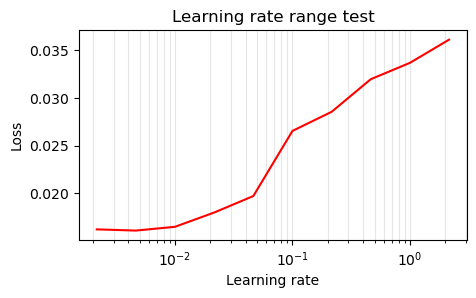

In [18]:
# Check the results
print(f"Number of loss values collected: {len(gpu_multisurv.lr_test.losses)}")
print(f"Number of learning rates tested: {len(gpu_multisurv.lr_test.lrs)}")
print(f"LR range: {min(gpu_multisurv.lr_test.lrs):.2e} to {max(gpu_multisurv.lr_test.lrs):.2e}")
print(f"Loss range: {min(gpu_multisurv.lr_test.losses):.6f} to {max(gpu_multisurv.lr_test.losses):.6f}")

# Plot the results to find optimal learning rate
gpu_multisurv.plot_lr_range(trim=1)

## Fit

In [19]:
# GPU-compatible fix for _predictions_to_pycox method
def gpu_fixed_predictions_to_pycox(self, preds, time_points=None):
    """GPU-compatible version that properly handles device transfers."""
    import pandas as pd
    import torch
    
    # preds shape is [num_patients, num_intervals] e.g., [864, 18]
    # Convert predictions to DataFrame (move to CPU first)
    df = pd.DataFrame(preds.detach().cpu().numpy())  # Added .detach() for GPU tensors
    
    if time_points is None:
        # Get the number of intervals from the model output
        n_intervals = preds.shape[1]  # Should be 18 for your model
        
        # Use the model's actual output intervals
        if hasattr(self, 'output_intervals') and self.output_intervals is not None:
            # Handle GPU tensors properly
            intervals = self.output_intervals
            if torch.is_tensor(intervals):
                intervals = intervals.detach().cpu()  # Move to CPU for calculations
            
            if len(intervals) > n_intervals:
                # Take the first n_intervals midpoints
                midpoints = (intervals[:-1] + intervals[1:]) / 2
                time_points = midpoints[:n_intervals]
            else:
                # Fallback to evenly spaced points
                last_interval = intervals[-1].item() if torch.is_tensor(intervals) else intervals[-1]
                time_points = torch.linspace(0.5, last_interval / 365, n_intervals)
        else:
            # Fallback: create time points that match the output size
            time_points = torch.arange(0.5, 0.5 + n_intervals, 1.0)
    
    # Ensure time_points matches the prediction dimensions
    if len(time_points) != preds.shape[1]:
        print(f"Warning: Adjusting time_points from {len(time_points)} to {preds.shape[1]}")
        first_point = time_points[0].item() if torch.is_tensor(time_points) else time_points[0]
        last_point = time_points[-1].item() if torch.is_tensor(time_points) else time_points[-1]
        time_points = torch.linspace(first_point, last_point, preds.shape[1])
    
    # FIXED: The DataFrame structure should be transposed
    # We want columns to be time points, rows to be patients
    df = df.T  # Transpose so shape becomes [num_intervals, num_patients]
    
    # Convert time_points to numpy if it's a tensor (ensure CPU)
    if torch.is_tensor(time_points):
        time_points = time_points.detach().cpu().numpy()
    
    # Set the index to time points
    df.index = time_points
    df.index.name = 'time'
    
    return df

# Apply the GPU-compatible fix to ModelCoach
from coach import ModelCoach
ModelCoach._predictions_to_pycox = gpu_fixed_predictions_to_pycox
print("✅ Applied GPU-compatible fix to ModelCoach._predictions_to_pycox method")

# Debug info with GPU handling
print(f"Model output intervals shape: {len(gpu_multisurv.output_intervals)}")
print(f"Model output intervals device: {gpu_multisurv.output_intervals.device}")
print(f"Model risk layer output: {gpu_multisurv.model.risk_layer[0].out_features}")
print(f"Expected: {len(gpu_multisurv.output_intervals) - 1} intervals for {len(gpu_multisurv.output_intervals)} breakpoints")

✅ Applied GPU-compatible fix to ModelCoach._predictions_to_pycox method
Model output intervals shape: 18
Model output intervals device: cuda:0
Model risk layer output: 17
Expected: 17 intervals for 18 breakpoints


In [20]:
# Cell 1: Setup with GPU verification
import os
import time
import utils
import torch
from datetime import datetime

# 1. Record start time
start_time = time.time()

# 2. Verify GPU setup before training
print("=== PRE-TRAINING GPU VERIFICATION ===")
print(f"GPU model device: {next(gpu_multisurv.model.parameters()).device}")
print(f"GPU intervals device: {gpu_multisurv.output_intervals.device}")
print(f"GPU device setting: {gpu_multisurv.device}")

# Check GPU memory
if torch.cuda.is_available():
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    print(f"GPU memory before training: {allocated:.2f} GB")

# 3. Set up training parameters
picked_lr = 5e-4
picked_num_epochs = 30
picked_info_freq = 5
picked_lr_factor = 0.5
picked_scheduler_patience = 5
picked_weight_decay = 5e-4

# Add timestamp to make unique run tags
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

run_tag = utils.compose_run_tag(
    model=gpu_multisurv, 
    lr=picked_lr,
    dataloaders=gpu_multisurv.dataloaders,
    log_dir='./training_logs/',
    suffix=f'_breast_cancer_gpu_{timestamp}'  # Added 'gpu' to indicate GPU training
)

# 4. Create log directory
log_dir = os.path.join('./training_logs/', run_tag)
os.makedirs(log_dir, exist_ok=True)
print(f"✅ Log directory created: {log_dir}")

print("✅ Setup complete - ready for GPU training!")

=== PRE-TRAINING GPU VERIFICATION ===
GPU model device: cuda:0
GPU intervals device: cuda:0
GPU device setting: cuda:0
GPU memory before training: 0.25 GB
Run tag: "clinical_lr0.0005_breast_cancer_gpu_20250705_140211"
✅ Log directory created: ./training_logs/clinical_lr0.0005_breast_cancer_gpu_20250705_140211
✅ Setup complete - ready for GPU training!


In [21]:
# Cell 2: Training execution with GPU monitoring
fit_args = {
    'lr': picked_lr,
    'num_epochs': picked_num_epochs,
    'info_freq': picked_info_freq,
    'lr_factor': picked_lr_factor,
    'scheduler_patience': picked_scheduler_patience,
    'log_dir': log_dir,
    'weight_decay':picked_weight_decay
}

print(f"🚀 Starting GPU training with LR: {picked_lr}")
print(f"📊 Expected to see GPU utilization spike during training")
print(f"📁 Logs will be saved to: {log_dir}")

# Function to monitor GPU during training
def check_gpu_status():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated(0) / 1024**3
        reserved = torch.cuda.memory_reserved(0) / 1024**3
        print(f"🎯 GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    else:
        print("❌ CUDA not available")


# Check GPU before training
print("\n=== GPU STATUS BEFORE TRAINING ===")
check_gpu_status()

# Clear any cached memory
torch.cuda.empty_cache()

# Start training
print(f"\n⏰ Training started at: {datetime.now().strftime('%H:%M:%S')}")

try:
    # This is where the actual training happens
    gpu_multisurv.fit(**fit_args)
    
    print(f"\n✅ Training completed successfully!")
    
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("This might be due to GPU memory issues or device mismatches")
    # Print more debug info
    print(f"Model device: {next(gpu_multisurv.model.parameters()).device}")
    import traceback
    traceback.print_exc()

# Check GPU after training
print("\n=== GPU STATUS AFTER TRAINING ===")
check_gpu_status()

# Calculate and display elapsed time
hrs, mins, secs = utils.elapsed_time(start_time)
print(f"\n⏰ Training completed in {hrs}h {mins}m {secs}s")
print(f"🏁 Training finished at: {datetime.now().strftime('%H:%M:%S')}")


🚀 Starting GPU training with LR: 0.0005
📊 Expected to see GPU utilization spike during training
📁 Logs will be saved to: ./training_logs/clinical_lr0.0005_breast_cancer_gpu_20250705_140211

=== GPU STATUS BEFORE TRAINING ===
🎯 GPU Memory: 0.25 GB allocated, 0.36 GB reserved

⏰ Training started at: 14:02:11
Instantiating MultiSurv model...
(loading pretrained unimodal model weights...)

------------------------------------------
             Training        Validation
           ------------     ------------
 Epoch     Loss     Ctd     Loss     Ctd
------------------------------------------


/opt/conda/envs/multisurv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 1/30     0.0174   0.600   0.0153   0.617
 5/30     0.0169   0.604   0.0148   0.429
 10/30    0.0158   0.656   0.0143   0.535
 15/30    0.0158   0.677   0.0143   0.582
 20/30    0.0152   0.680   0.0136   0.600
 25/30    0.0153   0.643   0.0137   0.634
 30/30    0.0148   0.705   0.0139   0.608

>>>>> Training completed in 1m 36s
>>>>> Best validation C-indices:
     0.6982968369829684 (epoch3)
     0.6861313868613139 (epoch17)
     0.6909975669099757 (epoch18)

✅ Training completed successfully!

=== GPU STATUS AFTER TRAINING ===
🎯 GPU Memory: 0.45 GB allocated, 0.60 GB reserved

⏰ Training completed in 0h 1m 37s
🏁 Training finished at: 14:03:48


In [27]:
import os
import time
import torch
import numpy as np
import glob
from datetime import datetime
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from collections import deque
import utils

class AutoTrainer:
    """Automated training system with intelligent decision making."""
    
    def __init__(self, gpu_model, device, models_dir='./models/', log_base_dir='./training_logs/'):
        self.model = gpu_model
        self.device = device
        self.models_dir = models_dir
        self.log_base_dir = log_base_dir
        
        # Training parameters
        self.base_lr = 1e-5
        self.num_epochs = 60
        self.info_freq = 5
        self.lr_factor = 0.5
        self.scheduler_patience = 5
        self.weight_decay = 1e-4
        
        # Decision thresholds
        self.overfitting_gap_warning = 0.15
        self.overfitting_gap_critical = 0.25
        self.overfitting_loss_ratio = 2.0
        self.convergence_variance = 0.02
        self.convergence_loss_variance = 0.001
        self.min_acceptable_performance = 0.55
        self.smoothing_window = 3
        
        # Training phases
        self.exploration_epochs = 20
        self.refinement_epochs = 40
        
        # Tracking
        self.checkpoint_candidates = {}  # epoch -> metrics
        self.training_history = {
            'train_loss': [], 'train_concord': [],
            'val_loss': [], 'val_concord': [],
            'smoothed_val_concord': []
        }
        self.lr_reductions = 0
        self.overfitting_warnings = 0
        
    def train(self, dataloaders):
        """Main training orchestration with automated decisions."""
        print("🚀 Starting Automated Training Process")
        start_time = time.time()
        
        # Setup training
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_tag = utils.compose_run_tag(
            model=self.model, 
            lr=self.base_lr,
            dataloaders=dataloaders,
            log_dir=self.log_base_dir,
            suffix=f'_auto_train_{timestamp}'
        )
        log_dir = os.path.join(self.log_base_dir, run_tag)
        os.makedirs(log_dir, exist_ok=True)
        
        # Initial setup
        current_lr = self.base_lr
        patience_counter = 0
        best_smoothed_concord = 0
        convergence_history = deque(maxlen=10)
        
        print(f"📁 Logs: {log_dir}")
        print(f"🎯 Initial LR: {current_lr}")
        
        # Training loop with checkpoints
        epoch = 0
        while epoch < self.num_epochs:
            # Determine training phase
            phase = self._get_training_phase(epoch)
            
            # Train for a batch of epochs
            batch_epochs = min(self.info_freq, self.num_epochs - epoch)
            
            fit_args = {
                'lr': current_lr,
                'num_epochs': batch_epochs,
                'info_freq': self.info_freq,
                'lr_factor': self.lr_factor,
                'scheduler_patience': self.scheduler_patience,
                'log_dir': log_dir,
                'weight_decay': self.weight_decay
            }
            
            try:
                print(f"\n📊 Training epochs {epoch+1}-{epoch+batch_epochs} (Phase: {phase})")
                self.model.fit(**fit_args)
                
                # Extract metrics from tensorboard logs
                metrics = self._extract_metrics_from_logs(log_dir, up_to_epoch=epoch+batch_epochs)
                
                # Update tracking
                self._update_tracking(metrics)
                
                # Get current performance
                current_metrics = self._get_current_metrics(epoch+batch_epochs)
                smoothed_concord = current_metrics['smoothed_val_concord']
                
                print(f"\n📈 Epoch {epoch+batch_epochs} Summary:")
                print(f"   Val Concord: {current_metrics['val_concord']:.4f} (smoothed: {smoothed_concord:.4f})")
                print(f"   Generalization gap: {current_metrics['gap']:.4f}")
                print(f"   Loss ratio: {current_metrics['loss_ratio']:.2f}")
                
                # Make decisions
                decision = self._make_decision(
                    current_metrics, phase, patience_counter, 
                    best_smoothed_concord, convergence_history
                )
                
                # Execute decision
                if decision['action'] == 'stop':
                    print(f"\n🛑 Stopping: {decision['reason']}")
                    break
                    
                elif decision['action'] == 'reduce_lr':
                    current_lr *= self.lr_factor
                    self.lr_reductions += 1
                    patience_counter = 0
                    print(f"\n📉 Reducing LR to {current_lr:.6f}")
                    
                elif decision['action'] == 'continue':
                    if smoothed_concord > best_smoothed_concord:
                        best_smoothed_concord = smoothed_concord
                        patience_counter = 0
                    else:
                        patience_counter += 1
                
                # Track checkpoint candidates
                if self._is_good_checkpoint(current_metrics, phase):
                    self._save_checkpoint_candidate(epoch+batch_epochs, current_metrics)
                
                # Update convergence history
                convergence_history.append(smoothed_concord)
                
            except Exception as e:
                print(f"\n❌ Training error: {e}")
                if "out of memory" in str(e).lower():
                    print("💡 Consider reducing batch size")
                break
            
            epoch += batch_epochs
        
        # Final checkpoint selection and evaluation
        print("\n🎯 Selecting best checkpoint...")
        best_checkpoint = self._select_best_checkpoint(dataloaders)
        
        # Final evaluation
        print("\n📊 Final Evaluation:")
        final_results = self._final_evaluation(best_checkpoint, dataloaders)
        
        # Training summary
        hrs, mins, secs = utils.elapsed_time(start_time)
        print(f"\n✅ Training completed in {hrs}h {mins}m {secs}s")
        print(f"🏆 Best checkpoint: Epoch {best_checkpoint['epoch']}")
        print(f"   Val Ctd: {final_results['val_ctd']:.4f}")
        print(f"   Test Ctd: {final_results['test_ctd']:.4f}")
        
        return {
            'best_checkpoint': best_checkpoint,
            'final_results': final_results,
            'run_tag': run_tag,
            'training_history': self.training_history
        }
    
    def _get_training_phase(self, epoch):
        """Determine current training phase."""
        if epoch < self.exploration_epochs:
            return 'exploration'
        elif epoch < self.refinement_epochs:
            return 'refinement'
        else:
            return 'fine-tuning'
    
    def _extract_metrics_from_logs(self, log_dir, up_to_epoch):
        """Extract metrics from tensorboard logs."""
        event_files = glob.glob(os.path.join(log_dir, "events.out.tfevents.*"))
        if not event_files:
            return None
            
        event_file = sorted(event_files, key=os.path.getmtime)[-1]
        ea = EventAccumulator(event_file, size_guidance={"scalars": 0})
        ea.Reload()
        
        metrics = {}
        for tag in ['train_loss', 'train_concord', 'val_loss', 'val_concord']:
            data = [(e.step, e.value) for e in ea.Scalars(tag) if e.step <= up_to_epoch]
            metrics[tag] = data
            
        return metrics
    
    def _update_tracking(self, metrics):
        """Update training history tracking."""
        if not metrics:
            return
            
        for key in self.training_history:
            if key != 'smoothed_val_concord' and key in metrics:
                # Add new values
                for step, value in metrics[key]:
                    if step >= len(self.training_history[key]):
                        self.training_history[key].append(value)
        
        # Update smoothed values
        if len(self.training_history['val_concord']) >= self.smoothing_window:
            vals = np.array(self.training_history['val_concord'])
            smoothed = np.convolve(vals, np.ones(self.smoothing_window)/self.smoothing_window, mode='valid')
            self.training_history['smoothed_val_concord'] = smoothed.tolist()
    
    def _get_current_metrics(self, epoch):
        """Get current training metrics."""
        metrics = {}
        
        # Get latest values
        if self.training_history['train_concord']:
            metrics['train_concord'] = self.training_history['train_concord'][-1]
        else:
            metrics['train_concord'] = 0.5
            
        if self.training_history['val_concord']:
            metrics['val_concord'] = self.training_history['val_concord'][-1]
        else:
            metrics['val_concord'] = 0.5
            
        if self.training_history['train_loss']:
            metrics['train_loss'] = self.training_history['train_loss'][-1]
        else:
            metrics['train_loss'] = 1.0
            
        if self.training_history['val_loss']:
            metrics['val_loss'] = self.training_history['val_loss'][-1]
        else:
            metrics['val_loss'] = 1.0
        
        # Smoothed concordance
        if self.training_history['smoothed_val_concord']:
            metrics['smoothed_val_concord'] = self.training_history['smoothed_val_concord'][-1]
        else:
            metrics['smoothed_val_concord'] = metrics['val_concord']
        
        # Derived metrics
        metrics['gap'] = metrics['train_concord'] - metrics['val_concord']
        metrics['loss_ratio'] = metrics['val_loss'] / max(metrics['train_loss'], 1e-6)
        
        return metrics
    
    def _make_decision(self, metrics, phase, patience_counter, best_smoothed, convergence_history):
        """Make training decision based on current metrics and phase."""
        decision = {'action': 'continue', 'reason': ''}
        
        # Check for convergence
        if len(convergence_history) >= 10:
            variance = np.var(list(convergence_history))
            if variance < self.convergence_variance and self.lr_reductions > 0:
                decision = {'action': 'stop', 'reason': 'Model converged'}
                return decision
        
        # Check for severe overfitting
        if metrics['gap'] > self.overfitting_gap_critical:
            decision = {'action': 'stop', 'reason': f'Severe overfitting (gap={metrics["gap"]:.3f})'}
            return decision
        
        # Check for poor performance
        if phase != 'exploration' and metrics['smoothed_val_concord'] < self.min_acceptable_performance:
            decision = {'action': 'stop', 'reason': f'Performance below threshold ({metrics["smoothed_val_concord"]:.3f})'}
            return decision
        
        # Phase-specific decisions
        if phase == 'exploration':
            # Be patient in exploration
            if patience_counter > 10:
                decision = {'action': 'reduce_lr', 'reason': 'No improvement in exploration'}
                
        elif phase == 'refinement':
            # More aggressive in refinement
            if patience_counter > 5:
                decision = {'action': 'reduce_lr', 'reason': 'No improvement in refinement'}
            elif metrics['gap'] > self.overfitting_gap_warning:
                self.overfitting_warnings += 1
                if self.overfitting_warnings > 3:
                    decision = {'action': 'reduce_lr', 'reason': 'Repeated overfitting warnings'}
                    
        else:  # fine-tuning
            # Very aggressive in fine-tuning
            if patience_counter > 3:
                decision = {'action': 'stop', 'reason': 'No improvement in fine-tuning'}
            elif metrics['loss_ratio'] > self.overfitting_loss_ratio:
                decision = {'action': 'stop', 'reason': f'High loss ratio ({metrics["loss_ratio"]:.2f})'}
        
        return decision
    
    def _is_good_checkpoint(self, metrics, phase):
        """Determine if current epoch is a good checkpoint candidate."""
        # Always save in exploration
        if phase == 'exploration':
            return True
            
        # Save if good performance and not overfitting
        return (metrics['smoothed_val_concord'] > 0.6 and 
                metrics['gap'] < self.overfitting_gap_warning and
                metrics['loss_ratio'] < 1.5)
    
    def _save_checkpoint_candidate(self, epoch, metrics):
        """Save checkpoint candidate information."""
        # Get actual model checkpoints
        if hasattr(self.model, 'best_model_weights'):
            available_epochs = list(self.model.best_model_weights.keys())
            
            # Find closest available epoch
            closest_epoch = None
            min_diff = float('inf')
            for avail_epoch in available_epochs:
                epoch_num = int(avail_epoch.replace('epoch', ''))
                diff = abs(epoch_num - epoch)
                if diff < min_diff:
                    min_diff = diff
                    closest_epoch = avail_epoch
            
            if closest_epoch and min_diff <= 2:  # Within 2 epochs
                self.checkpoint_candidates[closest_epoch] = metrics.copy()
    
    def _select_best_checkpoint(self, dataloaders):
        """Select best checkpoint by evaluating candidates on full validation set."""
        print("\n🔍 Evaluating checkpoint candidates...")
        
        best_checkpoint = None
        best_score = 0
        
        # Get available checkpoints
        available_checkpoints = []
        if hasattr(self.model, 'best_model_weights'):
            available_checkpoints.extend(list(self.model.best_model_weights.keys()))
        if hasattr(self.model, 'current_concord'):
            available_checkpoints.append('current')
        
        for checkpoint_epoch in available_checkpoints:
            # Load checkpoint
            try:
                # Save current state
                current_state = self.model.model.state_dict().copy()
                
                # Load checkpoint weights
                if checkpoint_epoch == 'current':
                    # Current weights are already loaded
                    pass
                else:
                    # Load from best_model_weights
                    checkpoint_state = self.model.best_model_weights[checkpoint_epoch]
                    self.model.model.load_state_dict(checkpoint_state)
                
                # Evaluate on full validation set
                performance = utils.Evaluation(
                    model=self.model,
                    dataset=dataloaders['val'].dataset,
                    device=self.device
                )
                performance.compute_metrics()
                
                # Get metrics
                val_ctd = performance.c_index_td if performance.c_index_td else 0
                val_ibs = performance.ibs if performance.ibs else 1.0
                
                # Composite score (prioritize Ctd, penalize high IBS)
                score = val_ctd - 0.1 * val_ibs
                
                print(f"  {checkpoint_epoch}: Ctd={val_ctd:.4f}, IBS={val_ibs:.4f}, Score={score:.4f}")
                
                if score > best_score:
                    best_score = score
                    best_checkpoint = {
                        'epoch': checkpoint_epoch,
                        'val_ctd': val_ctd,
                        'val_ibs': val_ibs,
                        'score': score
                    }
                
                # Restore original state
                self.model.model.load_state_dict(current_state)
                
            except Exception as e:
                print(f"  Error evaluating {checkpoint_epoch}: {e}")
                continue
        
        # Load best checkpoint
        if best_checkpoint:
            if best_checkpoint['epoch'] == 'current':
                # Already using current weights
                pass
            else:
                checkpoint_state = self.model.best_model_weights[best_checkpoint['epoch']]
                self.model.model.load_state_dict(checkpoint_state)
            print(f"\n✅ Selected {best_checkpoint['epoch']} as best checkpoint")
        
        return best_checkpoint
    
    def _final_evaluation(self, checkpoint, dataloaders):
        """Perform final evaluation on val and test sets."""
        results = {}
        
        # Validation set evaluation
        print("\n📊 Validation Set Performance:")
        val_performance = utils.Evaluation(
            model=self.model,
            dataset=dataloaders['val'].dataset,
            device=self.device
        )
        val_performance.compute_metrics()
        val_performance.show_results()
        
        results['val_ctd'] = val_performance.c_index_td if val_performance.c_index_td else 0
        results['val_ibs'] = val_performance.ibs if val_performance.ibs else 1.0
        
        # Test set evaluation
        print("\n📊 Test Set Performance:")
        test_performance = utils.Evaluation(
            model=self.model,
            dataset=dataloaders['test'].dataset,
            device=self.device
        )
        test_performance.compute_metrics()
        test_performance.show_results()
        
        results['test_ctd'] = test_performance.c_index_td if test_performance.c_index_td else 0
        results['test_ibs'] = test_performance.ibs if test_performance.ibs else 1.0
        
        # Save best weights
        if checkpoint:
            save_name = f"best_{checkpoint['epoch']}"
            self.model.save_weights(
                saved_epoch=checkpoint['epoch'], 
                prefix=f"auto_trained_{save_name}", 
                weight_dir=self.models_dir
            )
            print(f"\n💾 Saved best weights as: auto_trained_{save_name}")
        
        return results


# Usage example:
def run_automated_training(gpu_multisurv, dataloaders, device, models_dir='./models/'):
    """Run automated training with intelligent decision making."""
    
    # Initialize auto trainer
    trainer = AutoTrainer(
        gpu_model=gpu_multisurv,
        device=device,
        models_dir=MODELS
    )
    
    # You can customize parameters if needed
    # trainer.base_lr = 5e-4
    # trainer.num_epochs = 80
    # trainer.min_acceptable_performance = 0.60
    
    # Run training
    results = trainer.train(dataloaders)
    
    return results

# To use:
# results = run_automated_training(gpu_multisurv, dataloaders, device)

### Save model weights

If desired.

In [42]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import glob

# 1) Path to your events file:
events_path = os.path.join('/app', 'training_logs/' ,run_tag)
event_files = glob.glob(os.path.join(events_path, "events.out.tfevents.*"))
if not event_files:
    raise FileNotFoundError(f"No TensorBoard event files found in {events_path}")
event_file = sorted(event_files, key=os.path.getmtime)[-1]  # use the newest
print(f"Using event file: {event_file}")

# 2) Load all scalar data
ea = EventAccumulator(event_file, size_guidance={"scalars": 0})
ea.Reload()

# 3) Check available scalar tags
print("Available scalar tags:", ea.Tags()["scalars"])
# => ['train_loss', 'train_concord', 'val_loss', 'val_concord']

# 4) Extract (epoch, value) pairs for val_concord
val_concord = [(e.step, e.value) for e in ea.Scalars("val_concord")]

# 5) Separate epochs and values
epochs = [step for step, _ in val_concord]
vals   = np.array([v for _, v in val_concord])

# 6) Compute 3-epoch moving average
window = 3
# 'valid' mode produces len(vals) - window + 1 points
smoothed = np.convolve(vals, np.ones(window)/window, mode="valid")
smoothed_epochs = epochs[window - 1 :]  # first smoothed point corresponds to epoch=window

# 7) Find epoch with highest smoothed val_concord
best_idx = np.argmax(smoothed)
best_epoch = smoothed_epochs[best_idx]
best_smoothed_concord = smoothed[best_idx]
print(f"Best smoothed val_concord = {best_smoothed_concord:.4f} at epoch {best_epoch}")

# 8) (Optional) print raw vs smoothed for inspection
print("\n epoch │ raw val_concord │ smoothed")
print("───────┼─────────────────┼──────────")
for ep, raw, sm in zip(smoothed_epochs, vals[window - 1 :], smoothed):
    print(f"  {ep:>2d}   │      {raw:.4f}     │  {sm:.4f}")


Using event file: /app/training_logs/clinical_mRNA_lr0.001_breast_cancer_gpu_20250705_134207/events.out.tfevents.1751722932.a9fecd5a8321.63207.1
Available scalar tags: ['train_loss', 'train_concord', 'val_loss', 'val_concord']
Best smoothed val_concord = 0.6715 at epoch 38

 epoch │ raw val_concord │ smoothed
───────┼─────────────────┼──────────
   3   │      0.4440     │  0.5112
   4   │      0.5694     │  0.5231
   5   │      0.4923     │  0.5019
   6   │      0.4866     │  0.5161
   7   │      0.5977     │  0.5255
   8   │      0.6767     │  0.5870
   9   │      0.3755     │  0.5500
  10   │      0.4325     │  0.4949
  11   │      0.4885     │  0.4322
  12   │      0.3841     │  0.4350
  13   │      0.4933     │  0.4553
  14   │      0.4349     │  0.4374
  15   │      0.5211     │  0.4831
  16   │      0.6494     │  0.5351
  17   │      0.5081     │  0.5595
  18   │      0.5694     │  0.5757
  19   │      0.5738     │  0.5504
  20   │      0.6034     │  0.5822
  21   │      0.6456  

In [43]:
gpu_multisurv.best_model_weights.keys()

dict_keys(['epoch26', 'epoch32', 'epoch37'])

In [44]:
gpu_multisurv.best_concord_values

{'epoch26': 0.6772030651340997,
 'epoch32': 0.6772030651340997,
 'epoch37': 0.6934865900383141}

In [45]:
gpu_multisurv.current_concord

{'epoch40': 0.5909961685823755}

In [46]:
gpu_multisurv.save_weights(saved_epoch='epoch37', prefix=run_tag, weight_dir=MODELS)

Saving model weights to file:
    /mnt/data/multisurv_models/clinical_mRNA_lr0.001_breast_cancer_gpu_20250705_134207_epoch37_concord0.69.pth


## Check validation metrics

In [20]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='/app/data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     exclude_patients=exclude_cancers,
                                    return_patient_id=True,
                                   )

Data modalities:
   clinical

Dataset sizes (# patients):
   train: 710
   val: 165
   test: 219

Batch size: 128


In [21]:
# Fix for evaluation.py _predictions_to_pycox method

def fixed_evaluation_predictions_to_pycox(self, data, time_points=None):
    """Fixed evaluation version that handles the correct dimensions."""
    import pandas as pd
    import torch
    import numpy as np
    
    # Extract predictions from data
    # data should be a list of tuples: (predictions, times, events, patient_ids)
    predictions_list = []
    for item in data:
        pred = item[0]  # The prediction tensor
        if torch.is_tensor(pred):
            pred = pred.detach().cpu().numpy()
        predictions_list.append(pred)
    
    # Convert to numpy array
    predictions = np.array(predictions_list)
    
    # Create DataFrame
    df = pd.DataFrame(predictions)
    
    if time_points is None:
        # Get the number of intervals from the model output
        n_intervals = predictions.shape[1]  # Should be 18 for your model
        
        # Use the model's actual output intervals if available
        if hasattr(self, 'model') and hasattr(self.model, 'output_intervals') and self.model.output_intervals is not None:
            # Use the midpoints of the output intervals
            intervals = self.model.output_intervals
            if torch.is_tensor(intervals):
                intervals = intervals.detach().cpu().numpy()
            
            if len(intervals) > n_intervals:
                # Take the first n_intervals midpoints
                midpoints = (intervals[:-1] + intervals[1:]) / 2
                time_points = midpoints[:n_intervals]
            else:
                # Fallback to evenly spaced points
                last_interval = intervals[-1] if not torch.is_tensor(intervals) else intervals[-1].item()
                time_points = np.linspace(0.5, last_interval / 365, n_intervals)
        else:
            # Fallback: create time points that match the output size
            time_points = np.arange(0.5, 0.5 + n_intervals, 1.0)
    
    # Ensure time_points matches the prediction dimensions
    if len(time_points) != predictions.shape[1]:
        print(f"Warning: Adjusting time_points from {len(time_points)} to {predictions.shape[1]}")
        first_point = time_points[0] if len(time_points) > 0 else 0.5
        last_point = time_points[-1] if len(time_points) > 0 else n_intervals + 0.5
        time_points = np.linspace(first_point, last_point, predictions.shape[1])
    
    # FIXED: The DataFrame structure should be transposed
    # We want columns to be time points, rows to be patients
    df = df.T  # Transpose so shape becomes [num_intervals, num_patients]
    
    # Convert time_points to numpy if it's a tensor
    if torch.is_tensor(time_points):
        time_points = time_points.detach().cpu().numpy()
    
    # Set the index to time points
    df.index = time_points
    df.index.name = 'time'
    
    return df

# Apply the fix to the evaluation module
import evaluation

# Check if the _BaseEvaluation class exists and patch it
if hasattr(evaluation, '_BaseEvaluation'):
    evaluation._BaseEvaluation._predictions_to_pycox = fixed_evaluation_predictions_to_pycox
    print("✅ Applied fix to _BaseEvaluation._predictions_to_pycox")
else:
    print("❌ _BaseEvaluation class not found")

# Also check for Evaluation class
if hasattr(evaluation, 'Evaluation'):
    evaluation.Evaluation._predictions_to_pycox = fixed_evaluation_predictions_to_pycox
    print("✅ Applied fix to Evaluation._predictions_to_pycox")

# Fix the syntax warning too
def patch_syntax_warning():
    """Fix the syntax warning in evaluation.py if possible."""
    print("💡 Note: There's a syntax warning in evaluation.py line 187")
    print("   Change 'self.type is not 'MultiSurv'' to 'self.type != 'MultiSurv''")
    print("   This doesn't affect functionality but should be fixed in the source code")

patch_syntax_warning()

print("\n🔧 Evaluation fixes applied! Now try running your evaluation again.")

✅ Applied fix to _BaseEvaluation._predictions_to_pycox
✅ Applied fix to Evaluation._predictions_to_pycox
💡 Note: There's a syntax warning in evaluation.py line 187
   Change 'self.type is not 'MultiSurv'' to 'self.type != 'MultiSurv''
   This doesn't affect functionality but should be fixed in the source code

🔧 Evaluation fixes applied! Now try running your evaluation again.


In [22]:
# Fix the data shape issue in get_patient_predictions
def fixed_get_patient_predictions(self, idx):
    """Fixed version that handles 1D continuous tensor correctly."""
    patient_data = self.dataset[idx]
    data_dict, time, event = patient_data
    
    # Create batch data
    batch_data = {}
    for key, value in data_dict.items():
        if key == 'clinical' and isinstance(value, tuple):
            cat, cont = value
            # Fix: ensure continuous is 2D [1, n_features]
            if cont.dim() == 1:
                cont = cont.unsqueeze(0)
            batch_data[key] = (cat.unsqueeze(0).to(self.device), 
                              cont.unsqueeze(0).to(self.device))
        else:
            batch_data[key] = value.unsqueeze(0).to(self.device)
    
    # Get prediction
    with torch.no_grad():
        _, risk = self.model.model(batch_data)
    
    return risk.squeeze(0).cpu()

# Apply the fix
import evaluation
evaluation.Evaluation._get_patient_predictions = fixed_get_patient_predictions
print("✅ Applied clinical data shape fix to Evaluation._get_patient_predictions")

✅ Applied clinical data shape fix to Evaluation._get_patient_predictions


In [23]:
# Final fix for _predictions_to_pycox
def fixed_evaluation_predictions_to_pycox_final(self, data, time_points=None):
    """Fixed version that handles the nested dictionary structure."""
    import pandas as pd
    import torch
    import numpy as np
    
    # Extract predictions from the nested dictionary structure
    predictions_list = []
    times_list = []
    events_list = []
    patient_ids = []
    
    for patient_id, patient_data in data.items():
        if isinstance(patient_data, dict):
            # Extract probabilities from the dictionary
            prob = patient_data['probabilities']
            if torch.is_tensor(prob):
                prob = prob.detach().cpu().numpy()
            predictions_list.append(prob)
            
            # Also collect times and events for verification
            times_list.append(patient_data['time'])
            events_list.append(patient_data['event'])
            patient_ids.append(patient_id)
        else:
            # Fallback for other formats
            if torch.is_tensor(patient_data):
                predictions_list.append(patient_data.detach().cpu().numpy())
            else:
                predictions_list.append(patient_data[0])
    
    # Convert to numpy array
    predictions = np.array(predictions_list)
    print(f"Extracted predictions shape: {predictions.shape}")
    
    # Create DataFrame with patients as rows, time intervals as columns
    df = pd.DataFrame(predictions)
    
    if time_points is None:
        n_intervals = predictions.shape[1]
        
        # Use the model's actual output intervals if available
        if hasattr(self, 'model') and hasattr(self.model, 'output_intervals') and self.model.output_intervals is not None:
            intervals = self.model.output_intervals
            if torch.is_tensor(intervals):
                intervals = intervals.detach().cpu().numpy()
            
            # Create midpoints for time intervals
            if len(intervals) == n_intervals + 1:
                # intervals are boundaries, we need midpoints
                time_points = (intervals[:-1] + intervals[1:]) / 2
            else:
                # Fallback
                time_points = np.linspace(0.5, 20, n_intervals)
        else:
            # Fallback: create evenly spaced time points
            time_points = np.arange(0.5, 0.5 + n_intervals, 1.0)
    
    # Ensure time_points matches prediction dimensions
    if len(time_points) != predictions.shape[1]:
        time_points = np.linspace(0.5, 20, predictions.shape[1])
    
    # Transpose so time is the index (required by pycox)
    df = df.T
    df.index = time_points
    df.index.name = 'time'
    
    return df

# Apply the final fix
import evaluation
evaluation.Evaluation._predictions_to_pycox = fixed_evaluation_predictions_to_pycox_final
print("✅ Applied final fix for nested dictionary structure")

✅ Applied final fix for nested dictionary structure


In [27]:
performance = utils.Evaluation(
    model=gpu_multisurv, dataset=dataloaders['val'].dataset,
    device=device)
performance.compute_metrics()
performance.show_results()

Collect patient predictions: 165/165

Extracted predictions shape: (165, 17)
C-index   0.764
Ctd       0.764
IBS       0.237
INBLL     1.235


In [28]:
# Evaluate on TEST set (not validation)
performance = utils.Evaluation(
    model=gpu_multisurv, 
    dataset=dataloaders['test'].dataset,  # Note: 'test' not 'val'
    device=device
)
performance.compute_metrics()
performance.show_results()

Collect patient predictions: 219/219

Extracted predictions shape: (219, 17)
C-index   0.671
Ctd       0.672
IBS       0.325
INBLL     1.742


# Watermark <a class='tocSkip'></a>

In [ ]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

[Top of the page](#Top)